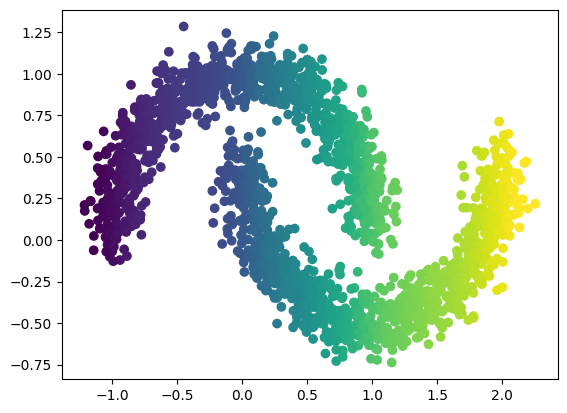

In [1]:
from util import moon
from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects
import numpy as np
import torch
%matplotlib inline

from sklearn.datasets import make_moons


np.random.seed(0)
torch.manual_seed(0)

n = 2000
# 生成 make_moons 数据集
x, y = make_moons(n_samples=n, noise=0.1
                  , random_state=42)
c = x[:, 0].argsort().argsort()
# scatter
plt.scatter(x[:, 0], x[:, 1], c=c)


# x,y = moon(n)
# c = x[:, 0].argsort().argsort()
# fig, ax = plt.figure(figsize=(5, 3)), plt.gca()
# ax.scatter(x[:, 0], x[:, 1], c=c, s=10, rasterized=True)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_facecolor('#eeeeee')
# txt = ax.text(0.05, 0.05, 'Ground Truth', color='k', fontsize=14, weight='bold', transform=ax.transAxes)
# txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='#eeeeee')])
# plt.savefig("./imgs/ground_truth.png")

In [2]:
import torch
import numpy as np
from sklearn.metrics import pairwise_distances
epsilon = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_train = int(n * 0.7)
train_ind = torch.randperm(n)[:n_train]
test_ind = torch.LongTensor(list(set(np.arange(n)) - set(train_ind.tolist())))
D = pairwise_distances(x)
fr, to = np.where(D < epsilon)
edges = list(zip(fr, to))

# edge_index = np.vstack([fr, to])
# edge_index = torch.tensor(edges, dtype=torch.long)
x = torch.tensor(x, dtype=torch.float).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)
edges = torch.tensor(edges, dtype=torch.long).t().contiguous()
edges.shape

torch.Size([2, 580742])

/home/jiaheng/anaconda3/envs/liuql_net/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data(x=[2000, 2], edge_index=[2, 580742], y=[2000])


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 100, Loss: 0.13936641812324524: 100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


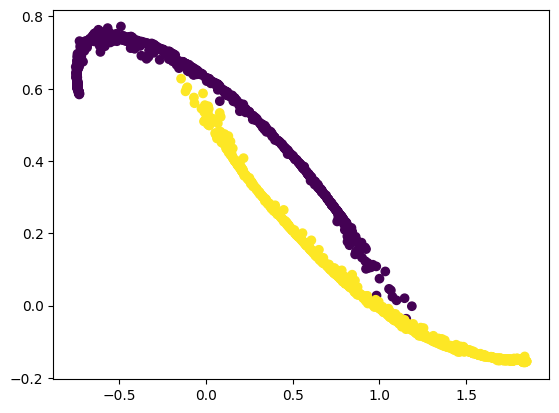

In [3]:
import torch
import torch.optim as optim
from torch_geometric.data import Data
from tqdm.auto import tqdm
from scipy.linalg import orthogonal_procrustes
import matplotlib.pyplot as plt
from util import GIN, GAT, dG, moon

# Create Data object
data = Data(x=x, y=y, edge_index=edges).to(device)
print(data)

# Initialize model and optimizer
m = 200
net = GAT(m).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()

# Training loop
pbar = tqdm(range(100))

for epoch in pbar:
    ind = torch.eye(n, device=device)[:, torch.randperm(n, device=device)[:m]]
    X_extended = torch.hstack([x, ind])  # Convert X to tensor
    data = Data(x=X_extended, edge_index=edges).to(device)
    rec = net(data)  # reconstruct
    loss = dG(x[train_ind], rec[train_ind])  # train loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    pbar.set_description(f'Epoch {epoch + 1}, Loss: {float(loss)}')

# Orthogonal Procrustes and visualization
R, _ = orthogonal_procrustes(x.cpu().numpy(), rec.detach().cpu().numpy())
rec_GAT = rec.detach().cpu().numpy() @ R.T
loss_GAT = float(dG(x, rec))
c = rec_GAT[:, 0].argsort().argsort()

plt.scatter(rec_GAT[:, 0], rec_GAT[:, 1], c=y.cpu())
plt.show()
# rec_GAT.shape


Epoch 100, Loss: 0.12867647409439087: 100%|██████████| 100/100 [00:01<00:00, 51.20it/s]


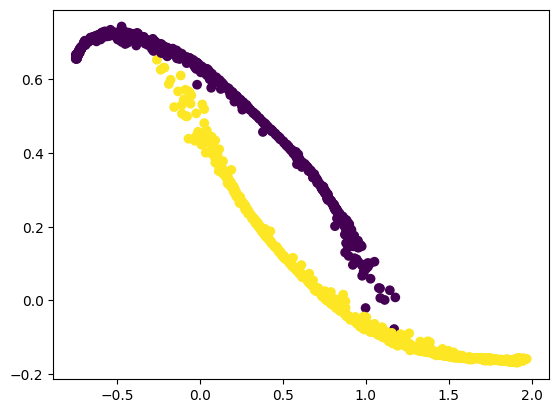

In [7]:
import torch
import torch.optim as optim
from torch_geometric.data import Data
from tqdm.auto import tqdm
from scipy.linalg import orthogonal_procrustes
import matplotlib.pyplot as plt
from util import GIN, GAT, dG, moon

# Initialize model and optimizer
m = 0
net = GAT(m).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()

# Training loop
pbar = tqdm(range(100))

for epoch in pbar:
    # ind = torch.eye(n)[:, torch.randperm(n)[:m]]
    # X_extended = torch.hstack([x, ind])  # Convert X to tensor
    data = Data(x=x, edge_index=edges).to(device)
    rec = net(data)  # reconstruct
    loss = dG(x[train_ind], rec[train_ind])  # train loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    pbar.set_description(f'Epoch {epoch + 1}, Loss: {float(loss)}')

# Orthogonal Procrustes and visualization
R, _ = orthogonal_procrustes(x.cpu().numpy(), rec.detach().cpu().numpy())
rec_GAT = rec.detach().cpu().numpy() @ R.T
loss_GAT = float(dG(x, rec))
c = rec_GAT[:, 0].argsort().argsort()

plt.scatter(rec_GAT[:, 0], rec_GAT[:, 1], c=y.cpu())
plt.show()
# rec_GAT.shape
